In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import random
from numba import jit

继续关于用Monte Carlo模拟的方法来研究betting strategy的文章，这是第三篇，目标是对 Martingale 策略进一步做一些分析。

前一篇的最后，分析了用 Martingale 策略当事先设定一个目标盈利时的表现，这相当于设置了「止盈位」，这一篇进一步看一下，如果再设置「止损位」会发生什么。

与前面相同的一些东西就不再重复了：

In [2]:
@jit(nopython=True)
def win_dice(n=49):
    roll = random.randint(1, 100)
    return bool(roll <= n)

wins = 0
losses = 0
for _ in range(1000000):
    if win_dice():
        wins += 1
    else:
        losses += 1
print('Win rate:', wins/1000000, '\tLoss rate:', losses/1000000)

Win rate: 0.488797 	Loss rate: 0.511203


对上一篇写的带止盈的函数作少量修改，加入止损的考虑：

In [3]:
@jit(nopython=True)
def martingale_leave_at_win_or_loss(funds, init_wager, wager_count, stop_profit, stop_loss):
    # stop_profit, stop_loss 为绝对金额
    # 返回了三种结果的状态和下注的次数，状态用数字表示 ，含义如下：
    # 1 ： 止盈，达到盈利目标，退出
    # 0 ： 直到最大下注数也没有发生上面情况（概率很低）
    # -1 ： 止损，亏损达到止损位，退出
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    win_previous = True
    previous_wager_amount = init_wager
    for i in range(wager_count):
        if win_previous:
            if win_dice():
                pass
                balance += wager
                win_previous = True
            else:
                balance -= wager
                win_previous = False
        else:
            wager = min(previous_wager_amount * 2, balance - (funds-stop_loss))
            if win_dice():
                balance += wager
                win_previous = True
                wager = init_wager
            else:
                balance -= wager
                win_previous = False
        previous_wager_amount = wager
        vY[i] = balance
        if balance >= funds + stop_profit:
            return 1, i+1, vY[:i+1]
        elif balance <= funds - stop_loss:
            return -1, i+1, vY[:i+1]

    return 0, i+1, vY

这个函数有一点改进，把 balance 的序列，即 vY 也返回了，避免了在函数体中画图，使得整个函数可以用 nopython 模式编译。测试一下速度：

In [4]:
stat, i, balance = martingale_leave_at_win_or_loss(100, 1, 10000, 25, 20)

%timeit stat, i, balance = martingale_leave_at_win_or_loss(100, 1, 10000, 15, 10)

10000 loops, best of 3: 32.1 µs per loop


测试一下上面的程序是不是有错误

4 8


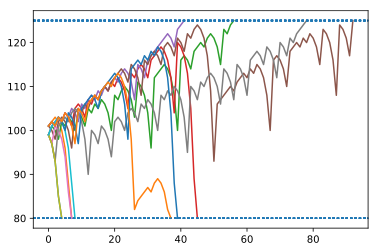

In [5]:
n_win = 0
n_loss = 0
for _ in range(12):
    stat, i, balance = martingale_leave_at_win_or_loss(100, 1, 10000, 25, 20)
    if stat == -1:
        n_loss += 1
    elif stat == 1:
        n_win += 1
    plt.plot(balance)
    plt.axhline(y=125, ls='dotted')
    plt.axhline(y=80, ls='dotted')
print(n_win, n_loss)

看起来结果似乎是正确的。再做一个验证，如果把止损或止赢设为1，这样就只能赌一次，理论上胜率是跟掷骰子的概率是相同的：

In [6]:
n_win = 0
n_loss = 0
n_sim = 1000000
stop_profit = 1
stop_loss = 1

for _ in range(n_sim):
    stat, i, _ = martingale_leave_at_win_or_loss(1000, 1, 10000, stop_profit, stop_loss)
    if stat == -1:
        n_loss += 1
    elif stat == 1:
        n_win += 1
    else:
        print('What are the odds?!')
print('Win percentage is {:.2f}, loss percentage is {:.2f}'.format(n_win/n_sim*100, n_loss/n_sim*100))

Win percentage is 49.01, loss percentage is 50.99


从结果来看确实如此，暂时认为上面的结果没有问题。

下面作一些更定量的分析：

1. 验证是不是任何止盈止损组合下期望值都是负的
2. 研究给定止盈线上最佳止损线是多少

为了限制参数的个数，把初始资金固定为1000，初始赌注固定为1。

先看第一点，验证**是不是任何止盈止损组合下期望值都是负的**：

In [7]:
n_sim = int(1e5)
params = [[10, 5], [10, 20], [10,30],  # low stop_profit
          [50, 25], [50, 50], [50, 100],  # normal stop_profit
          [200, 100], [200, 200], [200, 500]]

for param in params:
    n_win = 0
    n_loss = 0
    for _ in range(n_sim):
        stat, i, _ = martingale_leave_at_win_or_loss(1000, 1, 10000, param[0], param[1])
        if stat == -1:
            n_loss += 1
        elif stat == 1:
            n_win += 1
        else:
            print('What are the odds?!')
    print('Stop-profit {}, stop-loss {}.  Expectation is {:.2f}  ({:.2f}  {:.2f})'.format(param[0], param[1],
                                                                                          n_win/n_sim*param[0] - n_loss/n_sim*param[1],
                                                                                          n_win/n_sim*100, n_loss/n_sim*100))

Stop-profit 10, stop-loss 5.  Expectation is -0.39  (30.71  69.29)
Stop-profit 10, stop-loss 20.  Expectation is -0.98  (63.40  36.60)
Stop-profit 10, stop-loss 30.  Expectation is -1.07  (72.31  27.69)
Stop-profit 50, stop-loss 25.  Expectation is -3.42  (28.78  71.22)
Stop-profit 50, stop-loss 50.  Expectation is -5.15  (44.85  55.15)
Stop-profit 50, stop-loss 100.  Expectation is -6.63  (62.25  37.75)
Stop-profit 200, stop-loss 100.  Expectation is -17.51  (27.50  72.50)
Stop-profit 200, stop-loss 200.  Expectation is -25.13  (43.72  56.28)
Stop-profit 200, stop-loss 500.  Expectation is -39.04  (65.85  34.15)


上面模拟了9组不同止盈和止损位置的参数组合，涵盖了高低止盈和止损不同范围，所有的期望值都为负。

另外，也注意到对相同的止盈位，设置不同的止损位期望值也不同，而且似乎止损位设得越高（允许的损失越小），期望值越高，看看是不是这样：

50 10. 50 20. 50 50. 50 100. 50 200. 50 500. 100 10. 100 20. 100 50. 100 100. 100 200. 100 500. 200 10. 200 20. 200 50. 200 100. 200 200. 200 500. 

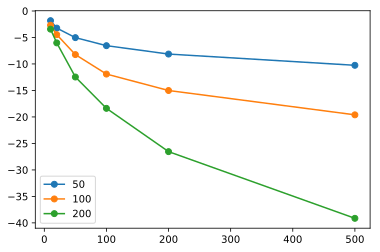

In [8]:
n_sim = int(1e5)
stop_profits = [50, 100, 200]
stop_losses = [10, 20, 50, 100, 200, 500]

for stop_profit in stop_profits:
    expectations = []
    for stop_loss in stop_losses:
        print(stop_profit, stop_loss, end='. ')
        n_win = 0
        n_loss = 0
        for _ in range(n_sim):
            stat, i, _ = martingale_leave_at_win_or_loss(1000, 1, 10000, stop_profit, stop_loss)
            if stat == -1:
                n_loss += 1
            elif stat == 1:
                n_win += 1
            else:
                print('What are the odds?!')
        expectations.append(n_win/n_sim*stop_profit - n_loss/n_sim*stop_loss)
    plt.plot(stop_losses, expectations, 'o-', label=str(stop_profit))
plt.legend(loc=0)

从这张图来看，结论还是很明显的，把止损位设得越高，最终期望值也会越高（尽管不管怎么努力都是负的）。

稍微想一下，似乎可以这样理解：在止盈位固定时，止损位设得越低，预期的下注次数就越多，也就是留在游戏中的时间更长，输的概率就越大。

当然其实参照前面验证期望值的那部分输出的结果，这样的理解原则上没有问题，但细节上其实是错的：因为止损位设得更低时，碰到止损位的概率其实也会降低，反而赢的概率会更高，但倒回来，尽管输的概率更低了，但概率上的降低并不足以抹平损失额的增长，总期望值还是降低的。

最后一点比较感兴趣的是，上一张图比较的是期望值的绝对值，而显然止盈位越高，输的也可能会更多，如果比较相对的期望值呢：

50 10. 50 20. 50 50. 50 100. 50 200. 50 500. 100 10. 100 20. 100 50. 100 100. 100 200. 100 500. 200 10. 200 20. 200 50. 200 100. 200 200. 200 500. 

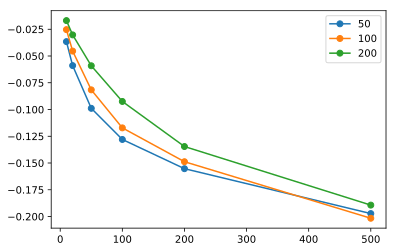

In [9]:
n_sim = int(1e5)
stop_profits = [50, 100, 200]
stop_losses = [10, 20, 50, 100, 200, 500]

for stop_profit in stop_profits:
    expectations = []
    for stop_loss in stop_losses:
        print(stop_profit, stop_loss, end='. ')
        n_win = 0
        n_loss = 0
        for _ in range(n_sim):
            stat, i, _ = martingale_leave_at_win_or_loss(1000, 1, 10000, stop_profit, stop_loss)
            if stat == -1:
                n_loss += 1
            elif stat == 1:
                n_win += 1
            else:
                print('What are the odds?!')
        expectations.append((n_win/n_sim*stop_profit - n_loss/n_sim*stop_loss) / stop_profit)
    plt.plot(stop_losses, expectations, 'o-', label=str(stop_profit))
plt.legend(loc=0)

从相对期望值来看，规律大致是倒过来的，当把止盈位设高时，相对的期望值也会更高一点。

前面的讨论都在看期望值，其实是有点偏离了「赌博」的本质了，毕竟这种游戏本质上肯定是输的。「赌博」有几种典型的心态：

1. 我有1000元，我想赌10把，赚到10%（100元）就走；
2. 我有1000元，我想玩10把，如果亏了10%就不玩了；
3. 我有1000元，我想一直玩，一直到赚了200或亏了100为止；

借助上面的工具，可以分别模拟这几种情况能达到目标的概率，这里就不再展开了。